className = RsiStrategy

author = 张华鸿

交易思路：这是一个做反转后的趋势的策略

交易逻辑：

60min：计算MA15 与MA33，判断趋势 --- Trend=1 or Trend=-1

15min：计算25RSI

多头开仓条件： Trend = 1，RSI[-1]40 多头止盈止损之后需等待RSI>40(过滤掉重复开仓的情况)

空头开仓条件: Trend = -1, RSI[-1]>60 aned RSI[-5]<60 空头止盈止损之后需等待RSI<60(过滤掉重复开仓的情况)

出场条件： 4%止损与12%止盈

In [9]:
# coding: utf-8
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate,
                                                     BarGenerator,
                                                     ArrayManager)

from collections import defaultdict
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime


class RsiStrategy(CtaTemplate):
    className = 'RsiStrategy'  # 策略和仓位数据表的名称
    author = 'HHH'

    # 策略交易标的
    symbol = EMPTY_STRING  
    posDict = {}  # 仓位数据缓存
    eveningDict = {}  # 可平仓量数据缓存
    bondDict = {}  # 保证金数据缓存

    # 策略参数
    fastWindow = 15     # 快速均线参数
    slowWindow = 33     # 慢速均线参数
    windowLength = 90        # ArrayManager的size   
    rsiLength = 25        # 计算RSI的窗口数
    rsiEntry = 10         # RSI的开仓信号
    trailingPercent = 0.4  # 百分比移动止损
    initDays = 1           # 初始化数据所用的天数
    fixedSize = 1           # 每次交易的数量
    stopRatio = 0.04        # 止损比例
    profitMultiplier = 3

    # 策略变量
    rsiValue = 0                        # RSI指标的数值
    rsiBuy = 0                          # RSI买开阈值
    rsiSell = 0                         # RSI卖开阈值
    intraTradeHigh = 0                  # 移动止损用的持仓期内最高价
    intraTradeLow = 0                   # 移动止损用的持仓期内最低价
    Trend = 0                           # 判断趋势
    transactionPrice = 0                # 成交价格
    TorR = 0                            # 止盈或止损后信号改变才交易（用于过滤信号）
    
    initbars = 100  # 获取历史数据的条数
    posSize= 1
    flag = 0
    fastMa0 = EMPTY_FLOAT  # 当前最新的快速EMA
    fastMa1 = EMPTY_FLOAT  # 上一根的快速EMA
    slowMa0 = EMPTY_FLOAT  # 当前最新的慢速EMA
    slowMa1 = EMPTY_FLOAT  # 上一根的慢速EMA
    maTrend = 0  # 均线趋势，多头1，空头-1
    transactionPrice = EMPTY_FLOAT  # 记录成交价格
    fixedSize = 1
    longStop = EMPTY_FLOAT
    shortStop = EMPTY_FLOAT

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'rsiLength',
                 'rsiEntry',
                 'fastWindow',
                 'slowWindow',
                 'stopRatio',
                 'profitMultiplier']   

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'posSize',
               'rsiValue',
               'rsiBuy',
               'rsiSell',
               'transactionPrice',
               'Trend',
               'TorR'] 

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict',
                'eveningDict',
                'bondDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""

        super(RsiStrategy, self).__init__(ctaEngine, setting)
        
        self.rsiBuy = 50 + self.rsiEntry
        self.rsiSell = 50 - self.rsiEntry
        
        self.intraTradeHighDict = {}
        self.intraTradeLowDict = {}
        # ----------------------------------------------------------------------

    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：初始化' % self.className)
        self.symbol = self.symbolList[0]

        # 构造K线合成器对象
        self.bgDict = {
            sym: BarGenerator(self.onBar)
            for sym in self.symbolList
        }
        
        self.amDict = {
            sym: ArrayManager()
            for sym in self.symbolList
        }

        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }

        self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
        self.bg15Dict = {
            sym: self.bg15

            for sym in self.symbolList
        }

        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.slowWindow + 10)
            for sym in self.symbolList
        }

        self.am15Dict = {
            sym: ArrayManager(size=self.slowWindow + 10)
            for sym in self.symbolList
        }


        self.putEvent()
        '''
        在点击初始化策略时触发,载入历史数据,会推送到onbar去执行updatebar,但此时ctaEngine下单逻辑为False,不会触发下单.
        '''
#         pastbar15 = self.loadHistoryBar(self.symbol,'15min',1000)[:-80]
#         pastbar60 = self.loadHistoryBar(self.symbol,'60min',1000)[:-20]
#         pastbar1 = self.loadHistoryBar(self.symbol,'1min',1200)

#         for bar15 in pastbar15:
#             self.am15Dict[self.symbol].updateBar(bar15)

#         for bar60 in pastbar60:
#             self.am60Dict[self.symbol].updateBar(bar60)

#         for bar1 in pastbar1:
#             self.onBar(bar1)

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：启动' % self.className)
        # self.ctaEngine.loadSyncData(self)    # 加载当前正确的持仓
        self.putEvent()
        '''
        在点击启动策略时触发,此时的ctaEngine会将下单逻辑改为True,此时开始推送到onbar的数据会触发下单.
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：停止' % self.className)
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """从错误状态恢复策略（必须由用户集成实现）"""
#         self.writeCtaLog(u'策略%s：恢复策略状态成功' % self.Name)
        self.putEvent()
    
    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        self.bgDict[tick.vtSymbol].updateTick(tick)
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到1分钟K线推送"""
        self.cancelAll()
        # 基于60分钟判断趋势过滤，因此先更新

        bg60 = self.bg60Dict[self.symbol]
        bg60.updateBar(bar)

        # 基于15分钟判断
        bg15 = self.bg15Dict[self.symbol]
        bg15.updateBar(bar)

        # 洗价器
        if (self.posDict[self.symbol+"_LONG"] > 0):
            if (bar.close < self.transactionPrice * (1 - self.stopRatio)) or (
                    bar.close > self.transactionPrice * (1 + self.profitMultiplier * self.stopRatio)):
                self.cancelAll()
                self.sell(self.symbol, bar.close*0.98, self.fixedSize, marketPrice="0",levelRate = 10)
                self.TorR = 1
                self.onStop()
#                 self.writeCtaLog('平多仓 止盈或止损')
        elif (self.posDict[self.symbol+"_SHORT"] > 0):
            if (bar.close > self.transactionPrice * (1 + self.stopRatio)) or (
                    bar.close < self.transactionPrice * (1 - self.profitMultiplier * self.stopRatio)):
                self.cancelAll()
                self.cover(self.symbol, bar.close*1.02 , self.fixedSize,marketPrice="0",levelRate = 10)
                self.TorR = -1
                self.onStop()
#                 self.writeCtaLog('平空仓 止盈或止损')
            
        self.putEvent()

        # ----------------------------------------------------------------------
    def on60MinBar(self, bar):
            """60分钟K线推送"""

            am60 = self.am60Dict[self.symbol]
            am60.updateBar(bar)

            if not am60.inited:
                return

            # 计算均线并判断趋势
            fastMa = ta.MA(am60.close, self.fastWindow)
            slowMa = ta.MA(am60.close, self.slowWindow)

            if fastMa[-1] > slowMa[-1]:
                self.Trend = 1
            else:
                self.Trend = -1

            # ----------------------------------------------------------------------
    def on15MinBar(self, bar):
            """收到Bar推送（必须由用户继承实现）"""
            self.cancelAll()

            am15 = self.am15Dict[self.symbol]
            am15.updateBar(bar)
            if not am15.inited:
                return
            rsiValue = ta.RSI(am15.close, self.rsiLength)
            
            if self.TorR == 0:
                if (self.posDict[self.symbol+"_LONG"] == 0) and (self.posDict[self.symbol+"_SHORT"] == 0):
#                     self.writeCtaLog('signa aa[-1]:%s, aa[-5]:%s,aa[-10]:%s,aa[-15]:%s,crossOver:%s,crossBelow:%s'%(aa[-1],aa[-5],aa[-10],aa[-15],crossOver,crossBelow))
                    if self.Trend==1:
                        if rsiValue[-1] < self.rsiSell and rsiValue[-5] >= self.rsiSell:
                            self.buy(self.symbol, bar.close*1.02 , self.fixedSize,marketPrice="0",levelRate = 10)
                    elif self.Trend==-1:
                        if rsiValue[-1] > self.rsiBuy and rsiValue[-5] <= self.rsiBuy:
                            self.short(self.symbol, bar.close*0.98, self.fixedSize,marketPrice="0",levelRate = 10)
            elif self.TorR == 1:
                if rsiValue[-1] > self.rsiSell:
                    self.TorR = 0
        
            # 上次空头止盈或止损
            elif self.TorR == -1:
                if rsiValue[-1] < self.rsiBuy:
                    self.TorR = 0
                        
            
            # 发出状态更新事件
            self.putEvent()

            # ----------------------------------------------------------------------



    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""

        self.putEvent()

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交信息变化推送"""
        #print("\n\n\n\n stg onTrade", trade.vtSymbol)
        self.transactionPrice = trade.price
#         print('trade direction',trade.direction,'offset',trade.offset,'price',trade.price, trade.dt)

#         self.writeCtaLog('onTrade price:%s'%trade.price)
        # self.saveSyncData()
        pass

    # ---------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [10]:
def runbacktest2(symboll):
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20180301 01:01',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180905 01:01')
    # 配置回测引擎参数
    engine.setSlippage(0.0002)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(100)     # 设置期货合约大小 100美金
    # engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(100000)  # 设置回测本金

    # # 在引擎中创建策略对象
    d = {'symbolList':[symboll]}          # 策略参数配置
    engine.initStrategy(RsiStrategy, d)    # 创建策略对象
    engine.runBacktesting()
    # 显示逐日回测结果
    engine.showDailyResult()
    # 显示逐笔回测结果
    engine.showBacktestingResult()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0} 
可平仓量: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2018-09-11 19:44:56.544351	开始回测
2018-09-11 19:44:56.544351	策略初始化
2018-09-11 19:44:56.545349	载入历史数据。数据范围:[20180228 01:01,20180301 01:01)
2018-09-11 19:44:56.567342	！！没有数据没有数据没有数据！！
2018-09-11 19:44:56.567342	策略初始化完成
2018-09-11 19:44:56.568342	策略启动完成
2018-09-11 19:44:56.568342	开始回放回测数据,回测范围:[20180301 01:01,20180905 01:01)
2018-09-11 19:44:56.605313	载入历史数据。数据范围:[20180301 01:01,20180905 01:01)
2018-09-11 19:46:02.874067	no Mongo connection, attempt using local data
2018-09-11 19:46:02.936032	载入完成，数据量：142060
2018-09-11 19:46:02.950021	当前回放数据:[20180301 01:01,20180905 01:01)
2018-09-11 19:46:06.394358	数据回放结束ss: 100%    
2018-09-11 19:46:06.394358	计算按日统计结果
2018-09-11 19:46:06.434333	------------------------------
2018-09-11 19:46:06.434333	首个交易日：	2018-05-28 00:00:00
2018-09-11 19:46:06.434333	最后交易日：	2018-09-05 00:00:00
2018-09-11 19:46:06.434333	总交易日：	101
2018-

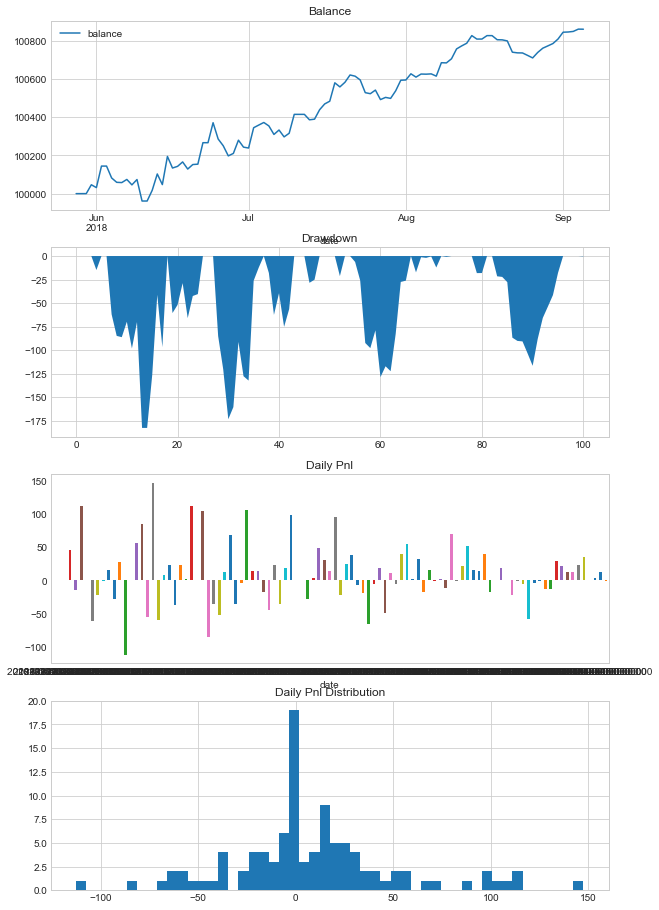

2018-09-11 19:46:08.400160	计算回测结果
单笔盈亏： 12.195735481136078 开仓： 2018-05-30 23:01:00 ,  11.795 平仓: 2018-06-02 16:23:00 ,  13.25 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -4.340493197750137 开仓： 2018-06-04 01:31:00 ,  14.4364 平仓: 2018-06-04 14:10:00 ,  13.83 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -4.2995882340184055 开仓： 2018-06-05 16:46:00 ,  13.8331 平仓: 2018-06-08 00:55:00 ,  14.4085 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -4.505612848200985 开仓： 2018-06-08 12:01:00 ,  13.8354 平仓: 2018-06-10 11:36:00 ,  13.2314 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 12.160202490198602 开仓： 2018-06-12 06:31:00 ,  11.6055 平仓: 2018-06-13 03:11:00 ,  10.178 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -4.427652645861611 开仓： 2018-06-14 10:46:00 ,  10.318 平仓: 2018-06-14 19:54:00 ,  10.7604 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 12.27245213388624 开仓： 2018-06-14 21:46:00 ,  10.0802 平仓: 2018-06-15 02:05:00 ,  11.3314 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -4.374242451883608 开仓： 2018-06-15 16:01:00 ,  1

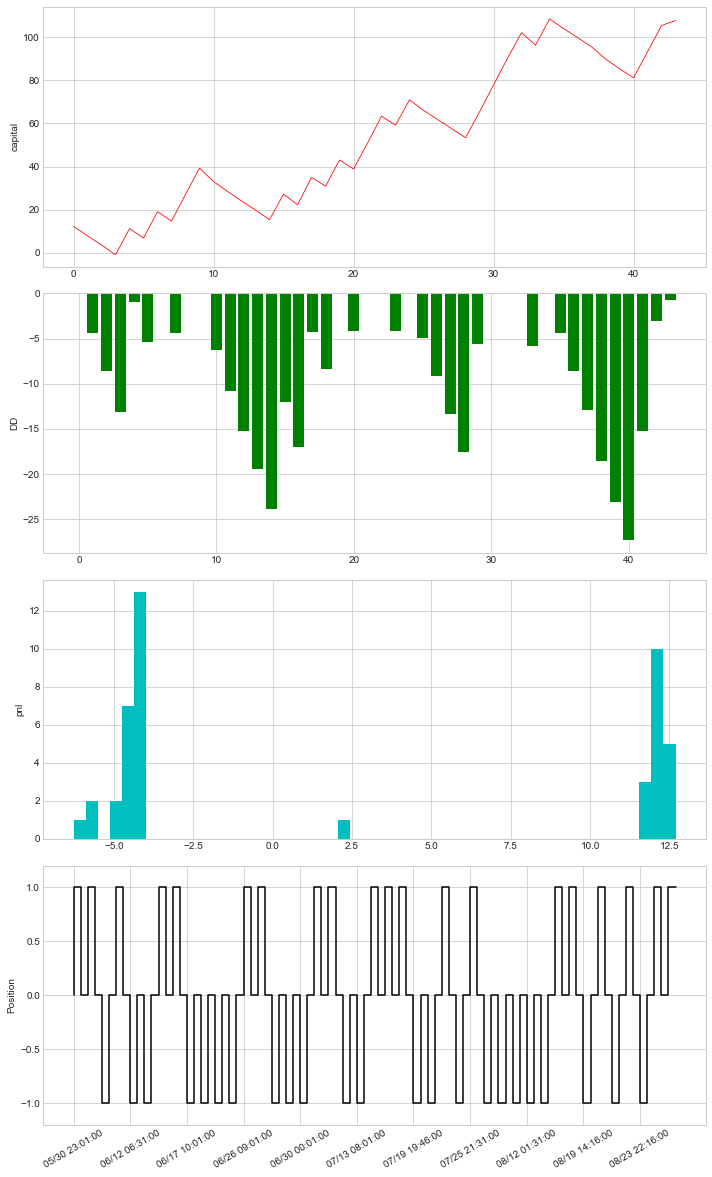

In [12]:
runbacktest2('EOSUSDT:binance')